**1. Brief Description of the Problem and Data:**

This challenge involves classifying images from a dataset as either cancerous or non-cancerous. The images are histopathological slides from biological samples of suspected cancer images; there are $50,000$ training images and $10,000$ test images. The training images are labeled $32$x$32$-px images of patches of tissue that either are or are not cancer tissue, while the test set are $32$x$ 32$ unlabeled patches.


**2. Exploratory Data Analysis: Inspect, Visualize, and Clean the Data**

First step is to load the packages we'll need to open, analyze, and interpret the data, as well as (at least some) of the relevant packages we'll need to create neural networks and models to learn the data and predict the occurrence of cancerous tissue samples in the test set.

Then we'll check to see what the .tif files look like and examine the distribution of cancerous and non-cancerous images. After that, the idea will be to take subsets of the large training set, train the model on that subset, and then predict the output of the test set. The main reason for using a subset rather than the full training is set is that the loading and learning run extremely slowly on this dataset and lead to problems with time-outs.

In [1]:
#Importing the relevant packages and libraries.
import tensorflow as tf

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from PIL import Image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Loading the data.
train_drct = '/kaggle/input/histopathologic-cancer-detection/train/'
test_drct = '/kaggle/input/histopathologic-cancer-detection/test/'

In [3]:
#The labels for the training data are provided in a different file; loading that here.
lbls = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
#Inspecting labels, confirming binary output.
lbls.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
print('Number of non-cancerous samples:', len(lbls[lbls.label==0]))
print('Number of cancerous samples:', len(lbls[lbls.label==1]))

Number of non-cancerous samples: 130908
Number of cancerous samples: 89117


([<matplotlib.axis.XTick at 0x7b68a799a080>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

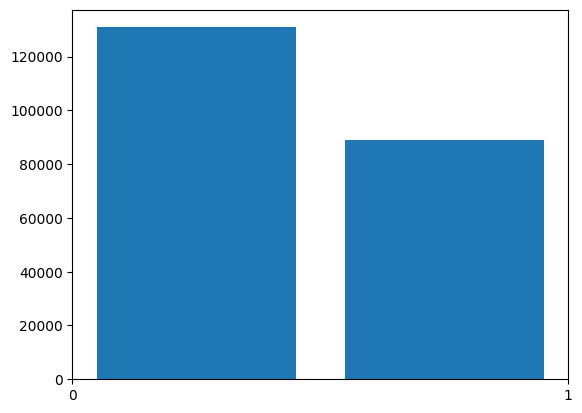

In [6]:
#Plotting the distribution of labels (cancerous and non-cancerous).
plt.hist(lbls.label, bins=2, rwidth=0.8)
plt.xticks([0,1])

In [7]:
#Splitting the labels and ids for reference.
img_name, img_lab = lbls.id, lbls.label

In [8]:
#What are the image names, and how are they referenced?
img_name

0         f38a6374c348f90b587e046aac6079959adf3835
1         c18f2d887b7ae4f6742ee445113fa1aef383ed77
2         755db6279dae599ebb4d39a9123cce439965282d
3         bc3f0c64fb968ff4a8bd33af6971ecae77c75e08
4         068aba587a4950175d04c680d38943fd488d6a9d
                            ...                   
220020    53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6
220021    d4b854fe38b07fe2831ad73892b3cec877689576
220022    3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75
220023    f129691c13433f66e1e0671ff1fe80944816f5a2
220024    a81f84895ddcd522302ddf34be02eb1b3e5af1cb
Name: id, Length: 220025, dtype: object

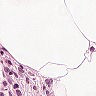

In [9]:
#Testing the 'open' function to see what the slides look like.
Image.open('/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif')

In [10]:
#Picking a random subset first; as this is the first time I've worked with this kind of data, 
#I'm working in small steps so I can troubleshoot
#without the challenge of having to disentangle problematic code from long run-time issues.

#Part of this is dealing with .tif files, opening them, transforming them into 255-RGB files, and
#and making them ready for interpretation.

np.random.seed(10) #Setting this for replicability
stop = len(lbls)
#def pull_images(start, stop, location_str): #Signature was (n, location_str), to accommodate a smaller, random set for a dry run.
def pull_images(n, location_str):    
    idxs = np.random.randint(low = 0, high = stop, size = n) #This was to pick a small, random subset.
    #idxs = np.arange(start, stop) #Introduced so I can pick larger groups and add them to the training and validation sets.
    np.random.shuffle(idxs)
    bigger_part = np.round(0.8 * len(idxs)).astype(np.int32)

    def make_img_dataset(arr, location_str):
        suffix = '.tif'
        pulled = []
        pulled_labs = []
        for idx in arr:#Was for idx in range(start, stop), before using this to split between training and validation sets.
            img_to_pull = str(location_str + img_name[idx] + suffix)
            ret_img = Image.open(img_to_pull)
            ret_img = ret_img.convert('RGB')
            ret_img_arr = np.array(ret_img) / 255
            pulled.append(ret_img_arr)
            pulled_labs.append(img_lab[idx])
        return pulled, pulled_labs
    
    pulled_tr, pulled_tr_labs = make_img_dataset(idxs[:bigger_part], location_str)
    pulled_val, pulled_val_labs = make_img_dataset(idxs[bigger_part:], location_str)
    return pulled_tr, pulled_tr_labs, pulled_val, pulled_val_labs

In [11]:
#Pulling our training data.
tr_sub, tr_sub_labs, val_sub, val_sub_labs = pull_images(10000, train_drct)

In [12]:
#Converting these into numpy arrays, for interpretation in the neural network:
tr_sub = np.array(tr_sub)
tr_sub_labs = np.array(tr_sub_labs)
val_sub = np.array(val_sub)
val_sub_labs = np.array(val_sub_labs)

In [13]:
#Looking at the shape of the inputs
print(tr_sub.shape)
print(tr_sub_labs.shape)

(8000, 96, 96, 3)
(8000,)


In [14]:
#Leaving this here to help clear the model for additional tweaks:
tf.keras.backend.clear_session()

**3. Model Architecture**

The goal for this problem is to use a convolutional neural network to interpret the histopathological slides and then predict whether a particular slide represents cancerous tissue or non-cancerous tissue. 

Thus the model will have effectively $2$ main sections: a convolutional neural network (CNN) which will filter, manage, and reduce into meaningful information the images and data, and an artificial neural network (ANN) which will learn from the data, interpret it, and ultimately predict whether the images represent cancerous tissue samples or not.

That "or not" portion at the end points to the activation function: a sigmoid activation function, which is useful with binary outputs. The CNN will feature padding, $3$x$3$ filters, and a ReLU activation function. The following sections show the model's architecture.

In [15]:
#tf.keras.Sequential model; here is where I'll add layers. The goal is to create a CNN, then add the ANN at the end.
#Input shape is 96x96.
#Starting with filter size 3x3.
model = models.Sequential()
model.add(layers.Conv2D(96, (3,3), padding='valid', activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))
model.add(layers.Conv2D(96, (3,3), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(layers.Conv2D(96, (3,3), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(layers.Conv2D(96, (3,3), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 96)          │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 93, 93, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 91, 91, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 43, 43, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 21, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 96)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,808 (983.62 KB)

 Trainable params: 251,808 (983.62 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#Now adding the ANN: 1 flatten layer, 2 dense layers. For the first dense layer, arbitrarily adding 192 units, as that is 96*2.
model.add(layers.Flatten())
model.add(layers.Dense(192))
model.add(layers.Dense(1)) #Size of the output is 1, as this is binary classification
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 96)          │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 93, 93, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 91, 91, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 43, 43, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 21, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 192)                 │       1,493,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,745,185 (6.66 MB)

 Trainable params: 1,745,185 (6.66 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#Examining some loss functions.
predictions = model(tr_sub[:1]).numpy()
print(predictions)
softmax_pred = tf.nn.softmax(predictions).numpy()
print(softmax_pred)
sigmoid_pred = tf.nn.sigmoid(predictions).numpy()
print(sigmoid_pred)

[[0.12471971]]
[[1.]]
[[0.53113955]]


In [18]:
#Probably not close enough. Trying sigmoid, with binary crossentropy as the loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_val = loss_fn(tr_sub_labs[:1], predictions).numpy()
theoretical_loss_val = -tf.math.log(1/2)
print(loss_val, theoretical_loss_val)

0.6327305 tf.Tensor(0.6931472, shape=(), dtype=float32)


In [19]:
optim = tf.keras.optimizers.Adam(0.001)
optim.learning_rate.assign(0.01)
print(optim.learning_rate)

<KerasVariable shape=(), dtype=float32, path=adam/learning_rate>


In [20]:
model.compile(optimizer=optim, loss=loss_fn, metrics=['accuracy'])
history = model.fit(tr_sub, tr_sub_labs, batch_size = 256, epochs=3, validation_data=(val_sub, val_sub_labs))

Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 603s 19s/step - accuracy: 0.5359 - loss: 94.4488 - val_accuracy: 0.5815 - val_loss: 0.6730
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 598s 19s/step - accuracy: 0.5890 - loss: 0.6711 - val_accuracy: 0.5815 - val_loss: 0.6843
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 594s 19s/step - accuracy: 0.5891 - loss: 0.6734 - val_accuracy: 0.5815 - val_loss: 0.6779


In [21]:
#Now that the model has been trained, it will be used to predict output labels for the test file.
#This output will be saved as a .csv file for submission to the competition.
#First, preparing the test data.
test_set = []
test_refs = []
test_img_names = os.listdir(test_drct)
for i in range(len(test_img_names)):
    img_to_pull = str('/kaggle/input/histopathologic-cancer-detection/test/'+test_img_names[i])
    ret_img = Image.open(img_to_pull)
    ret_img = ret_img.convert('RGB')
    ret_img_arr = np.array(ret_img) / 255
    test_set.append(ret_img_arr)
    test_refs.append(test_img_names[i][:-4])

In [ ]:
#Now, making the predictions:
y_preds = model.predict(test_set)
output = (y_preds<0.5).astype(int)

In [ ]:
#And finally, producing the output file.
output_vals = []
for i in range(len(output)):
    val = output[i][0]
    output_vals.append(val)

submission = pd.DataFrame({'id': test_data.id, 'target':output_vals})
print(submission.head())
submission.to_csv('submission.csv', index=False)

## 4. Discussion of Results and Conclusions

Accuracy improved after multiple tweaks and adjustments to hyperparameters. One limitation related to memory and the size of the dataset. I had difficulty running the model given the size of the training set as well as limitations with running TPU clusters through Kaggle, and also with running a higher number of epochs (most of my initial models ran with at least $10$ epochs, which required a prohibitively large amount of training time). Making those adjustments might have further improved the model.

Despite these limitations, the existing CNN-ANN architecture was sufficient to successfully classify much of the training and test datasets. Subsequent efforts that involve architectural refinements with a view toward overcoming infrastructural limitations can be tried in future submissions with the goal of improving the model further.